# South Park network analysis
South park is an animated sitcom created by Trey Parker and Matt Stone. The Show debuted on August 13, 1997 and there has been produced 23 seasons and 2 specials since. South Park is about the 4 friends, Eric Cartman, Stan Marsh, Kyle Broflovski and Kenny McCormick. The show is characterized by having many odd and improbable characters that is both made up, but also includes parodies of celebrities and public figures. The show often involves with controversy and taboo subjects. 

### Our inspiration
South park is a tv show that has existed as long as we can remember, we have therefore grown up with it. South park has a tendency to make shock value humor which speaks to a lot of young people. "The fuck everything" kind of mentality is excatly what we find fun and entertaining. The show has evolved through the years, we therefore thought it would be interesting to dig into how the characters interlink with each other and how the language has changed thorugh the seasons. 

### Goal for the project 
This notebook will give an introduction to the south park network. It will look at how characters interlink with each other and show stats from the network. It consists of commentary and explanations of the analysis. The analysis will be on basic stats, but will also dig into sentiment analysis of the main characters and how their language evolve through the seasons. The characters categories, which appear on the wiki page, will also be investigated to see if they correspond to the communities that can be found from the GCC. 


# Basic stats 
The dataset is from southpark.fandom.com where we download all character pages and episode scripts. A character link to another character if the other character is mentioned in its character page. This way a digraph can be created for characters that interact with each other.
A csv file called ["characters.csv"](https://github.com/koldbrandt/socialgraphs/blob/main/characters.csv) has been created. The csv has a column with the character name and another column with a list containing the characters that the character link to. The 4 other columns are the characters categories. Where 'mainCategories' are all its categories and 'subCategory1' refers to its primary category.  
The directed network has been created and the gcc has been found. Both of them are saved in the github as a pickle file. The files can be found [here](https://github.com/koldbrandt/socialgraphs/tree/main/network).

### Getting the data and cleaning

First we needed to get all the characters from the show. Looking at the characters page of the fandom wiki we noticed that all character names/pages are reffered the same way by having `[[character name]]`. This made for a simple regular expression to get all of these and then removing the '[' and ']'.  
The regular expression looks like the following:  
`'\[\[[a-zA-Z0-9\'\\ -.]*\]\]'`  
This simply states that we get a word or multiple inside double square brackets. The words can have some special characters, which is listed in the regular expression. From this we get 1837 different characters. where they each have different categories which we will come back to later. 

Now when all character names has been found the character page can be downloaded and saved as txt. The downloaded pages ca be found on the github. From these pages a digraph can be created. This will be done by finding all links to other characters on the characters page and then create a directed link between them. To subtract the links a regex has been used. The pattern for a link is as followed `[[character name|alias]]` and sometimes just with the character name. This gives a very smiliar regex as used earlyer, just with some more special characters in it and then some more cleaning is used afterwards. The regex looks like the following:  
`\[\[*[A-Za-z _()\|\']*\]\]`  
From this the links just have to get split by '[', ']' and '|'. Then the link can be taken out and a graph can be created. The csv file mentioned earlier has all the characters that it links to in a column. 

The category for each character is listed in the bottom of the character page. The pattern for categries are `[[Category: category name]]`. This gives a regex that looks like the following:  
`r'(?<=[[Category:)(.*?)(?=])'`  
This will give a list of all the categories that a character is part of. There is however some categories that are really huge and almost involve all characters, this is categories like 'characters' and 'female characters'. 

To see how all characters and their pages has been download look [here](https://github.com/koldbrandt/socialgraphs/blob/main/SP_get_characters.ipynb).

### Undirected graph 
Some basic stats for the undirected graph will now be shown and commented.

In [1]:
import requests
import re
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
from fa2 import ForceAtlas2
import seaborn as sns
import numpy as np
from pprint import pprint
from PIL import Image
from math import log
import random 
from matplotlib import colors as mcolors
sns.set()

Loading in the undirected GCC.

In [2]:
G = nx.read_gpickle("SouthParkUnirectedGCC.gpickle")

 We will start with showing some stats on the network. Here are number of nodes, edges and a list of the 5 most connected characters.

In [3]:
def printBasicStats(G):
    print("Basic stats for the gcc network:")
    N = len(G.nodes())
    K = sum(dict(G.degree()).values())/N
    d = log(N)/log(K)
    print("Number of nodes: ", N)
    print("Number of edges: ", len(G.edges()))
    print("Average degree: ", K)
    print("Average distance between 2 nodes: ", d)
    print("\n5 most connected characters: " )
    degree_list = sorted(G.degree, key=lambda x: x[1], reverse=True)
    for node, degree in degree_list[0:5]:
        print(f'{node}: {degree} edges')
printBasicStats(G)

Basic stats for the gcc network:
Number of nodes:  1559
Number of edges:  5718
Average degree:  7.335471456061578
Average distance between 2 nodes:  3.6893259739524686

5 most connected characters: 
Eric Cartman: 523 edges
Stan Marsh: 349 edges
Kyle Broflovski: 299 edges
Butters Stotch: 240 edges
Randy Marsh: 233 edges


When looking at the 5 most connected characters then it is interesting that Kenny McCormick is not one of them, since he is one of the 4 main characters of the show. An explanation to this could be that he never really talks in the show, but he mumbles through everything and it can therefore be hard to understand the character. Butters and Randy are highly connected since they are a big part of the show. 

We want to show the degree distribution of the network.

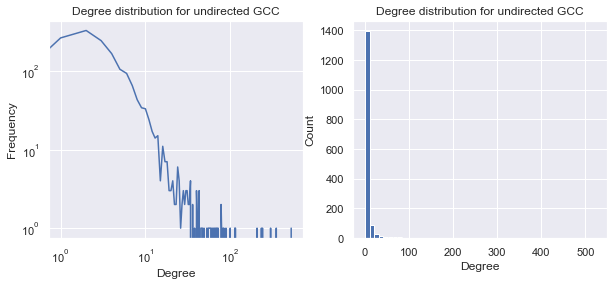

In [4]:
f, ax = plt.subplots(1, 2, figsize=(10, 4))
degree_freq = nx.degree_histogram(G)
degrees = range(len(degree_freq))
ax[0].loglog(degrees, degree_freq,'-') 
ax[0].set_xlabel('Degree')
ax[0].set_ylabel('Frequency')
ax[0].set_title("Degree distribution for undirected GCC")
degrees = [val for (node, val) in G.degree()]
d1 = np.array(degrees)
ax[1].hist(d1, bins = 50) 
ax[1].set_xlabel('Degree')
ax[1].set_ylabel('Count')
_= ax[1].set_title("Degree distribution for undirected GCC")

The degree distrbibution tells us that the network is not random. This is expected since we have some characters that are in every episode of the show and a lot of characters that only show in a single episode or a few. This gives a very uneven distribution through the network. 

Now we can plot the network using forceatlas2. The nodes will be colored in regards to their category, the edges will be the color that the node that it pointing to has and the size of nodes will be found from its degree. 

setting node size depending on degree

In [5]:
d = dict(G.degree)
node_sizes = [8*v for v in d.values()]

Loading in the csv files with all characters and their category

In [6]:
df_characters =  pd.read_csv('characters.csv')

Making a list of colors for each edge. This is done by making a dictionary where key is category and value is a color. Then mapping each node together with a color depending on its category.

In [11]:
categories = list(set(df_characters.subCategory1.values))
num_colors=len(set(categories))
colors=list(mcolors.CSS4_COLORS.keys())
cluster_colors=random.choices(colors, k=num_colors)

color_dict = {}
for i in range(len(categories)):
    color_dict[categories[i]] = cluster_colors[i]

node_color = []
for node in G.nodes():
    cat = df_characters[df_characters.Name == node].subCategory1.values[0]
    node_color.append(color_dict[cat])

It can now be plottet using forceatlas 2

In [8]:
# Setup FA2 w. parameters
forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=True,    # Dissuade hubs
    edgeWeightInfluence=1.0,

    # Performance
    jitterTolerance=1.0,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=1.2,

    # Tuning
    scalingRatio=1.0,
    strongGravityMode=False,
    gravity=0.2,

    # Log
    verbose=True

    
)

# compute node positions with the fa algorithm
node_pos = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

100%|██████████| 2000/2000 [01:12<00:00, 27.52it/s]

BarnesHut Approximation  took  10.03  seconds
Repulsion forces  took  60.26  seconds
Gravitational forces  took  0.17  seconds
Attraction forces  took  0.15  seconds
AdjustSpeedAndApplyForces step  took  0.94  seconds


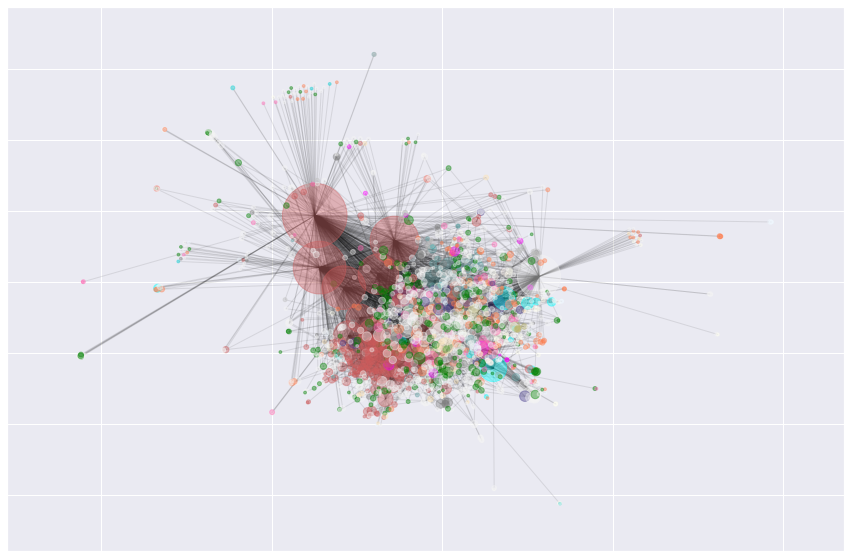

In [13]:
plt.figure(figsize=(15, 10))
_ = nx.draw_networkx_nodes(G, node_pos, nodelist=d.keys(), node_size=node_sizes, alpha=0.4, node_color = node_color)
_ = nx.draw_networkx_edges(G, node_pos, alpha=0.1)

From this it is clear to see that there are a handfull of hubs that almost all other nodes connect to. This is also what we saw when looking at the degree distribution plot, that there were a few characters that had a lot of nodes connected to them. There are also a lot of nodes with only a few edges, which is expected since some characters are only part of 1 or a few episodes. The hubs have the same color, which makes sense since they primarily have the category '4.th grader'.

### Directed Graph
We will now look at the basic stats for the directed GCC. We are starting by loading it in and getting the basic stats for the graph. 

Starting by loading in the directed gcc

In [15]:
G = nx.read_gpickle("SouthParkDirectedGCC.gpickle")

Printing some basic stats for the network.

In [16]:
def printBasicStats(G):
    print("Basic stats for the gcc network:")
    N = len(G.nodes())
    K = sum(dict(G.degree()).values())/N
    d = log(N)/log(K)
    print("Number of nodes: ", N)
    print("Number of edges: ", len(G.edges()))
    print("Average degree: ", K)
    print("Average distance between 2 nodes: ", d)
    print("\n5 most in degree: " )
    in_deg = sorted(G.in_degree, key=lambda x: x[1], reverse=True)
    for node, degree in in_deg[0:5]:
        print(f'{node}: {degree} edges')
    print("\n5 most out degree: " )
    out_deg = sorted(G.out_degree, key=lambda x: x[1], reverse=True)
    for node, degree in out_deg[0:5]:
        print(f'{node}: {degree} edges')
    
printBasicStats(G)

Basic stats for the gcc network:
Number of nodes:  1559
Number of edges:  6714
Average degree:  8.613213598460552
Average distance between 2 nodes:  3.4142053787134055

5 most in degree: 
Eric Cartman: 510 edges
Stan Marsh: 342 edges
Kyle Broflovski: 295 edges
Butters Stotch: 230 edges
Randy Marsh: 222 edges

5 most out degree: 
Eric Cartman: 89 edges
Heidi Turner: 75 edges
Douchebag: 45 edges
Stan Marsh: 42 edges
Wendy Testaburger: 40 edges


This shows that there are 996 more edges in the directed graph. Average degree is higher since we can have edges going both ways between nodes. The average distance between 2 nodes are about the same as in the undirected, this is expected.  
The 5 most connected characters in regards to in degree are actually same as in the undirected graph. That is the same characters is somewhat expected since they are main characters in the show. The 5 most connected characters in regard to out degree is a bit more surprising since Heidi turner and douchebag is in the list. Heidi Turner is a main character in the series and is the most popular girl in the 4.th grade, and therefore it makes a bit sense that she has a lot of out degrees. Douchebag or "The new kid" as he is also known by is from the two video games that has been created. It does therefore also make sense that he is a key person in the network.

Lets look at the degree distribution of both in degree and out degree. 

In [104]:
degrees_in = np.array([d for _, d in G.in_degree])
degrees_out = np.array([d for _, d in G.out_degree])
in_deg, in_deg_count = np.unique(degrees_in, return_counts=True)
out_deg, out_deg_count = np.unique(degrees_out, return_counts=True)

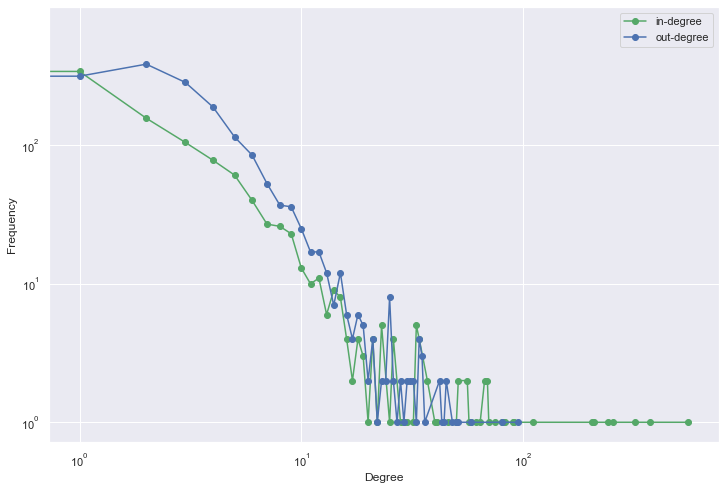

In [105]:
plt.figure(figsize=(12, 8)) 
plt.loglog(in_deg, in_deg_count, 'go-', label='in-degree') 
plt.loglog(out_deg, out_deg_count, 'bo-', label='out-degree')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.legend()
_ = plt.show

As the plot shows then in and out degree do follow each other pretty well. It shows that the hubs or main characters has a lot more in degrees than the rest of the network and lays flat on on the x axis. There is a lot of characters with a single or a few links, which also makes sense since there are characters only showing in a single or a few episodes.  

# Analysis 

## Wordclouds 

To give a overview of the most used words on the character pages, for the 4 main characters, wordclouds can be created. The wordclouds will show the most common words big an the less common words smaller. To do so cleaning of the character pages is needed. There is a lot of brackets containing links or basic stats like age etc. This will have to removed for every single page. This is done by using a number fo regex that substitutes it by an empty string. 

## Communities and categories in south park 

## Sentiment analysis through time

The tv show has run for many years and therefore an interesting thing to look at is how the sentiment has evolved over the years. The focus will be on the 4 main characters and how their sentimental analysis score evolves through the years. The 4 main characters has very different personalities which is also something that we hope will be shown in the sentiment analysis.

The focus will be on their dialogue from all the epsiodes. A dataset can be created from the scripts of every episode and then take out the text where one of the 4 main characters are talking. This has been saved to a csv file that can be read in to a pandas dataframe. The csv is called Character_lines_episodes.csv and can be found in the github. 

In [112]:
df_character_lines=pd.read_csv('Character_lines_episodes.csv')
df_character_lines['Clean_text'] = df_character_lines['Clean_text'].replace(np.nan, "")

In [113]:
df_character_lines.head()

,Character,Episode,Clean_text,Season
0,Cartman,101,I know what it means! I'm not telling you. He-...,1
1,Cartman,102,"Ugh, I hate those things. Well, you know, you'...",1
2,Cartman,103,"Okay, Mom. Dude, that's sick mom. Drive, Drive...",1
3,Cartman,104,"Eh. You're making me sick, dude. No way. Every...",1
4,Cartman,105,"Hey Stan, where'd you get that black eye? Your...",1


From this dataframe the sentiment analysis for each character can be done. Vader will be used for sentiement analysis, since it can find sentiment in whole sentences and not just for a lemmatized text. 

In [114]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download('vader_lexicon')

Calculating the sentiment scores

In [115]:
# Calculates scores
df_character_lines['Sentiment_Scores'] = df_character_lines['Clean_text'].apply(lambda x: sid.polarity_scores(x))
df_character_lines = pd.concat([df_character_lines, df_character_lines['Sentiment_Scores'].apply(pd.Series)], axis=1)

A plot can now be created with the average compound score for each character over a season. This way it can be seen how the sentiment evolves through the seasons for every main character. 

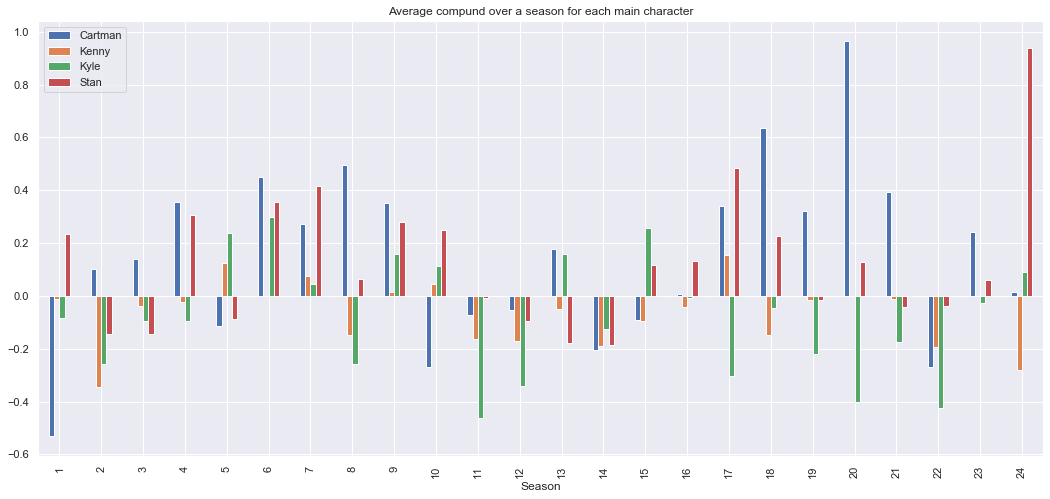

In [116]:
fig, ax = plt.subplots()
_ = df_character_lines.groupby(['Season', 'Character']).agg(Season_avg_compound=('compound', 'mean')).unstack('Character')\
        .plot(kind='bar',figsize=(18,8), ax = ax, title= "Average compund over a season for each main character")
_ = ax.legend(["Cartman", "Kenny",'Kyle', 'Stan'])

As it can be seen the sentiment compound score almost evolves like a sinus curve. It is interesting to look at cartman, since he will be seen by many to very rude to other people. It is then interesting to see that he has a rather positive sentiment in many of the seasons. Eventhough kenny doesn't say much he is still get a negative compound score. This probably reflects that he is not the happiest guy in the show and comes from a less wealthy family and are always moped by the other characters. Stan is clearly the most happy person in the group, which is also expected. Kyle is mostly negative, but has some seasons where he is positive.   
Vader do not understand sarcasm, which is a big part of the show. This can also have influenced the score. 